In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    num = 0
    for filename in filenames:
        num += 1
        #print(os.path.join(dirname, filename))
    print("{}  {}",dirname,num)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

{}  {} /kaggle/input 0
{}  {} /kaggle/input/gauss-s1-00-nl0-30-b0-01 50000
{}  {} /kaggle/input/gauss-s1-00-nl0-30-b0-00-0 50000
{}  {} /kaggle/input/gauss-s1-00-nl0-30-b0-50 50000
{}  {} /kaggle/input/gauss-1-0-0-3 4000
{}  {} /kaggle/input/gauss-s1-00-nl0-30-b0-50-jet 6000


In [38]:
"""
    DataSet库说明-
    读取文件路径-img_dir
    读取50,000张图片
    输出为 X, Y
    X是（10000，4,56,56） 1000表示样本数 4表示通道数（包含四个emcal hcal trkn trkp)
    Y是（10000,56,56）
"""
# 导入相关库
import os # 与系统文件交互
import tifffile as tiff #读取tiff文件格式
from PIL import Image #图片处理
#与torch 相关的库
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

#from sklearn.preprocessing import MinMaxScaler
import numpy as np
import imageio 

class MaxMinNormalizeGlobalPerChannel:
    """
    针对 (Batch, Channel, Width, Height) 的张量，
    在所有 Batch 中对每个通道整体进行最大最小归一化。
    """
    def __call__(self, tensor):
        # 确保输入是 (Batch, Channel, Width, Height) 的张量
        assert tensor.dim() == 4, "Input tensor must have 4 dimensions: (Batch, Channel, Width, Height)."
        
        # 计算每个通道在所有 Batch 上的全局最小值和最大值
        # 结果是 (Channel, 1, 1)
        min_vals = tensor.amin(dim=(0, 2, 3), keepdim=True)  # 在 Batch、Width、Height 维度求最小值
        max_vals = tensor.amax(dim=(0, 2, 3), keepdim=True)  # 在 Batch、Width、Height 维度求最大值
        
        # 最大最小归一化公式
        tensor = (tensor - min_vals) / (max_vals - min_vals + 1e-8)
        
        return tensor


#创建数据集
class MyDataSet(Dataset):
    def __init__(self,img_dir,group_size=10000,size_in=10000,transform=None,
                split_shuffle = True,splition = True):
        self.img_dir=img_dir
        self.images=os.listdir(img_dir)
        self.transform=transform
        self.all_imgs=[]
        self.emcal=[]
        self.hcal=[]
        self.trkn=[]
        self.trkp=[]
        self.truth=[]
        self.group_size=group_size
        self.size_in=size_in
        self.splition=splition
        self.split_shuffle = split_shuffle
        self.load_images()
        #self.normalize()
    
    def load_images(self):
        all_imgs=[]
        to_pil = transforms.ToPILImage()
        for filename in self.images:
            if filename.endswith(".tiff") and (filename.startswith('jet')!=True):
                img_path=os.path.join(self.img_dir, filename)
            img_array=tiff.imread(img_path)
            img=Image.fromarray(img_array)
            img_tensor=transform(img)
            all_imgs.append(img_tensor)
        self.emcal=all_imgs[:self.size_in]
        self.hcal=all_imgs[self.group_size:self.group_size+self.size_in]
        self.trkn=all_imgs[2*self.group_size:2*self.group_size+self.size_in]
        self.trkp=all_imgs[3*self.group_size:3*self.group_size+self.size_in]
        self.truth=all_imgs[4*self.group_size:4*self.group_size+self.size_in]
        
        self.X=[]
        self.Y=[]
        picture = np.ndarray([])
        
        if self.transform is not None:
            transformation = self.transform
            print('transformation is not None')
        else:
            transformation = lambda x: x
            print('transformation is None')
        
        for emcal, hcal, trkn, trkp in zip(self.emcal,self.hcal,self.trkn, self.trkp):
            combined_features=torch.stack((emcal,hcal,trkn,trkp),dim=0).reshape(-1,56,56)
            self.X.append(combined_features)
        
        self.X=torch.stack(self.X).squeeze()
        self.X=transformation(self.X)
        self.Y=torch.stack(self.truth)
        self.Y=transformation(self.Y)
        
        N = self.X.size(0)
        train_size = int(0.8 * N)
        val_size = int(0.1 * N)
        if self.split_shuffle:
            indices = torch.randperm(N)

        else:
            indices = torch.arange(N)
            # 按照比例划分索引
        train_indices = indices[:train_size]
        val_indices = indices[train_size:train_size + val_size]
        test_indices = indices[train_size + val_size:]
        if self.splition == True:
            # 根据索引划分数据集
            self.train_X = self.X[train_indices]
            self.train_Y = self.Y[train_indices]
            self.val_X = self.X[val_indices]
            self.val_Y = self.Y[val_indices]
            self.test_X = self.X[test_indices]
            self.test_Y = self.Y[test_indices]
            # 释放内存
            del self.X
            del self.Y



    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx], self.Y[idx]
transform=transforms.Compose([
    transforms.ToTensor(),
    # 数据预处理后期添加
])

    
class dataset_2(Dataset):
    def __init__(self,X,Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx], self.Y[idx]

In [22]:
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

class CNN_5layer(nn.Module):
    def __init__(self):
        super(CNN_5layer,self).__init__()
        self.cov3x3 = nn.Conv2d(4, 2, kernel_size=3, padding=1)
        self.cov5x5 = nn.Conv2d(4, 2, kernel_size=5, padding=2)
        self.cov7x7 = nn.Conv2d(4, 2, kernel_size=7, padding=3)

        self.encoder=nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # self.se1=SEBlock(128)
        self.decoder=nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=5, padding=2),
            nn.Conv2d(16, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
    def forward(self,x): #x=torch.cat((emcal,hcal,trkn,trkp),dim=1) (4,56,56)
        x1=self.cov3x3(x)
        x2=self.cov5x5(x)
        x3=self.cov7x7(x)
        x = torch.cat((x1,x2,x3),dim=1)
        x=self.encoder(x)
        x=self.decoder(x)
        return x
    
class CNN_8layer(nn.Module):
    def __init__(self):
        super(CNN_8layer,self).__init__()

        self.encoder=nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 56x56 -> 28x28
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(256, 512, kernel_size=5, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),   # 14x14 -> 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 28x28 -> 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
    def forward(self,x): #x=torch.cat((emcal,hcal,trkn,trkp),dim=1) (4,56,56)
        x=self.encoder(x)
        x=self.decoder(x)
        return x

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D,self).__init__()
        self.conv3x3x3 = nn.Conv3d(1, 2, kernel_size=3, padding=(0,1,1))
        self.conv3x5x5 = nn.Conv3d(1, 2, kernel_size=(3,5,5), padding=(0,2,2))
        self.conv3x7x7 = nn.Conv3d(1, 2, kernel_size=(3,7,7), padding=(0,3,3))

        self.encoder=nn.Sequential(
            nn.Conv2d(12, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.decoder=nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=5, padding=2),
            nn.Conv2d(16, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
    def forward(self,x): #x=torch.cat((emcal,hcal,trkn,trkp),dim=1) (4,56,56)
        x = x.unsqueeze(1)
        x_e_h_n = x[:,:,:3,:,:]
        x_e_h_p = x[:,:,[0,1,3],:,:]
        x2 = self.conv3x3x3(x_e_h_n)
        x3 = self.conv3x5x5(x_e_h_n)
        x4 = self.conv3x7x7(x_e_h_n)
        x5 = self.conv3x3x3(x_e_h_p)
        x6 = self.conv3x5x5(x_e_h_p)
        x7 = self.conv3x7x7(x_e_h_p)
        x = torch.cat((x2,x3,x4,x5,x6,x7),dim=1).view(-1,12,56,56)
        x=self.encoder(x)
        x=self.decoder(x)
        return x
    
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock,self).__init__()
        self.fc1=nn.Linear(channels,channels//reduction,bias=False)
        self.fc2=nn.Linear(channels//reduction,channels,bias=False)

    def forward(self,x):
        b, c,_,_=x.size()
        y = F.adaptive_avg_pool2d(x, (1, 1)).view(b, c) # Squeeze
        y=F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1) # Excitation - 2nd layer
        return x * y.expand_as(x) # Scale

class CNN_with_SEBlock(nn.Module):
    def __init__(self):
        super(CNN_with_SEBlock,self).__init__()

        self.encoder=nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2, 2),  # 56x56 -> 28x28
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(256, 512, kernel_size=5, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )
        self.se1=SEBlock(512)
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),   # 14x14 -> 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 28x28 -> 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
    def forward(self,x): #x=torch.cat((emcal,hcal,trkn,trkp),dim=1) (4,56,56)
        x=self.encoder(x)
        x=self.decoder(x)
        return x
    
class Conv_UNet(nn.Module):
    def __init__(self, C_in, C_out):
        super(Conv_UNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(C_in, C_out, kernel_size=3, stride=1, padding=1),  # 3x3卷积，padding=1保持尺寸不变
            nn.BatchNorm2d(C_out),
            nn.Dropout(0.3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(C_out, C_out, kernel_size=3, stride=1, padding=1),  # 再次保持尺寸不变
            nn.BatchNorm2d(C_out),
            nn.Dropout(0.4),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)

class DownSampling_UNet(nn.Module):
    def __init__(self, C_in, C_out):
        super(DownSampling_UNet, self).__init__()
        self.Down = nn.Sequential(
            nn.Conv2d(C_in, C_out, kernel_size=2, stride=2),  # 2x2卷积，步幅2会让特征尺寸减半
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.Down(x)

class UpSampling_UNet(nn.Module):
    def __init__(self, C_in, C_out):
        super(UpSampling_UNet, self).__init__()
        self.Up = nn.Conv2d(C_in, C_out, kernel_size=1)  # 改变通道数的卷积

    def forward(self, x, r):
        up = F.interpolate(x, scale_factor=2, mode='nearest')  # 使用最近邻插值进行上采样
        x = self.Up(up)  # 改变输出通道数
        x = torch.cat([x, r], dim=1)  # 进行跳跃连接，拼接特征
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.C1 = Conv_UNet(4, 64)  # 输入图像有4个通道
        self.D1 = DownSampling_UNet(64, 128)  # 下采样
        self.C2 = Conv_UNet(128, 128)
        self.D2 = DownSampling_UNet(128, 256)  # 第二次下采样
        self.C3 = Conv_UNet(256, 256)
        self.U1 = UpSampling_UNet(256, 128)  # 第一次上采样
        self.C4 = Conv_UNet(256, 128)  # 拼接后通道数为256
        self.U2 = UpSampling_UNet(128, 64)  # 第二次上采样
        self.C5 = Conv_UNet(128, 64)  # 拼接后通道数为128
        self.pred = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()  # 对最终输出使用Sigmoid激活函数

    def forward(self, x):
        R1 = self.C1(x)  # 第1层卷积
        R2 = self.C2(self.D1(R1))  # 下采样后卷积
        R3 = self.C3(self.D2(R2))  # 第二次下采样后卷积
        up1 = self.U1(R3, R2)  # 第一次上采样，并进行跳跃连接
        up2 = self.U2(R1, up1)  # 第二次上采样，并进行跳跃连接

        c = self.C5(up2)  # 最后一层卷积
        return self.sigmoid(self.pred(c))  # 进行最后的预测并激活

class SelfAttention_UNetwithattention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention_UNetwithattention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1) #H*W->H*W
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, H, W = x.size()
        # 生成查询、键、值
        queries = self.query(x).view(batch_size, C, -1) # (B, C, H*W)
        keys = self.key(x).view(batch_size, C, -1) # (B, C, H*W)
        values = self.value(x).view(batch_size, C, -1) # (B, C, H*W)

        # 计算自注意力
        attention_scores = torch.bmm(queries.permute(0, 2, 1), keys) # (B, H*W, H*W)
        attention_scores = self.softmax(attention_scores)

        out = torch.bmm(values, attention_scores.permute(0, 2, 1)) # (B, C, H*W)
        return out.view(batch_size, C, H, W) #不改变形状

# 定义U-Net与Transformer结合的模型
class UNetwithattention(nn.Module):
    def __init__(self, in_channels, out_channels=1): # 输出通道调整为1
        super(UNetwithattention, self).__init__()
        # 编码器部分
        self.enc1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1) # 输入通道为4 
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # 自注意力层
        self.attention = SelfAttention_UNetwithattention(128) #输入256个通道进入
        # 解码器部分
        self.dec1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv1=nn.Conv2d(256,128,kernel_size=1)
        self.dec2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec3 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1) # 最终输出通道为1
        self.conv2=nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(128,64,kernel_size=1)
    def forward(self, x):
        # 编码
        enc1 = F.relu(self.enc1(x)) # 4*56*56->64*56*56
        enc2 = F.relu(self.enc2(F.max_pool2d(enc1, 2))) #64*28*28->128*28*28
        enc3 = F.relu(self.enc3(F.max_pool2d(enc2, 2))) #128*14*14->256*14*14
        # 自注意力
        attn_out = self.attention(enc3) # 256*14*14->256*14*14
        # 解码
        dec1=F.relu(self.dec1(F.upsample(attn_out,scale_factor=2,mode='bilinear',align_corners=False))) #128*28*28
        dec1=torch.cat([dec1,enc2],dim=1) # 256*28*28
        dec1=self.conv1(dec1)
        dec2 = F.relu(self.dec2(F.upsample(attn_out, scale_factor=2, mode='bilinear', align_corners=False))) #128*28*28->64*56*56
        dec3 = torch.cat([dec2, enc1], dim=1) # 跳跃连接
        dec4=self.conv2(dec3) #B 64 56 56
        dec5 = self.conv3(dec4)
        out = self.dec3(dec5) #64*56*56->1*56*56
        
        return out
    


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()
        
        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
        embed_dim: int,
        # vision
        image_resolution: int,
        vision_layers: Union[Tuple[int, int, int, int], int],
        vision_width: int,
        vision_patch_size: int,
        # text
        context_length: int,
        vocab_size: int,
        transformer_width: int,
        transformer_heads: int,
        transformer_layers: int
        ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        #logit_scale=self.logit_scale
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp32(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp32)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()


class easyCNN(nn.Module):
    def __init__(self):
        super(easyCNN,self).__init__()

        self.encoder=nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 56x56 -> 28x28
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(256, 512, kernel_size=5, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),   # 14x14 -> 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 28x28 -> 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
    def forward(self,x): #x=torch.cat((emcal,hcal,trkn,trkp),dim=1) (4,56,56)
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [4]:
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import os


def train_one_epoch(model, optimizer, data_loader, device, epoch, loss_function):
    model.train()
    mean_loss = torch.zeros(1).to(device)
    
    data_loader = tqdm(data_loader, file=sys.stdout)
    
    for step, (batch_X, batch_Y) in enumerate(data_loader):
        optimizer.zero_grad()
        outputs=model(batch_X.to(device))
        loss=loss_function(outputs,batch_Y.to(device))
        loss.backward()
        optimizer.step()
        
        mean_loss = (mean_loss * step + loss.detach()) / (step + 1)  # update mean losses
        # 打印平均loss
        data_loader.desc = "[epoch {}] mean loss {}".format(epoch, round(mean_loss.item(), 7))
        
        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)
        
        
    return mean_loss.item()


@torch.no_grad()
def evaluate(model, data_loader, device, loss_function):
    mean_loss = torch.zeros(1).to(device)
    model.eval()
    val_loss = 0
    for batch_X, batch_Y in data_loader:
        outputs=model(batch_X.to(device))
        mean_loss += loss_function(outputs,batch_Y.to(device)).detach()
    mean_loss /= len(data_loader)
    return mean_loss.item()

@torch.no_grad()
def plot_image(net, data_loader, device, label):
    batch_size = data_loader.batch_size
    plot_num = min(batch_size, 5)
    net.eval()
    fig_list = []
    for batch_X, batch_Y in data_loader:
        outputs=net(batch_X.to(device)).detach()
        for i in range(plot_num):
            fig = plt.figure()
            fig.suptitle(label, fontsize=16)
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122)
            ax1.imshow(batch_Y[i].cpu().numpy().squeeze(),cmap='jet')
            ax1.axis('off')
            ax1.set_title('Ground Truth')
            ax2.imshow(outputs[i].cpu().numpy().squeeze(),cmap='jet')
            ax2.axis('off')
            ax2.set_title(f'Prediction')
            
            fig_list.append(fig)
        break
    return fig_list

In [11]:
#导入模块
#from DataSet import MyDataSet, MaxMinNormalizeGlobalPerChannel
#from model import CNN3D
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
#from dataset_2 import dataset_2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import time
import numpy as np
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from scipy.stats import norm
import random

random.seed(26)
np.random.seed(26)
torch.manual_seed(26)
torch.cuda.manual_seed(26)
torch.cuda.manual_seed_all(26) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
#超参数设计
BATCH_SIZE = 200
num_epochs = 300
LEARNING_RATE=0.01
HEIGHT=56
WIDTH=56

In [13]:
#导入数据集，数据预处理，加载数据迭代器
data_transform = {
	"without_jet": transforms.Compose([MaxMinNormalizeGlobalPerChannel()]),
	"jet": transforms.Compose([MaxMinNormalizeGlobalPerChannel()])}

dataset = MyDataSet(img_dir='/kaggle/input/gauss-s1-00-nl0-30-b0-50', group_size=10000, splition = False, transform=data_transform["without_jet"])

# 归一化处理，把所有像素值归一化到0-1
X=dataset.X #(10000,4,56,56)
Y=dataset.Y #(10000,1,56,56)

transformation is not None


In [14]:
torch.save(X, '/kaggle/working/X_dataset_general.pt')
torch.save(Y, '/kaggle/working/Y_dataset_general.pt')

In [ ]:
X = torch.load('/kaggle/working/X_dataset_general.pt')
Y = torch.load('/kaggle/working/Y_dataset_general.pt')

In [15]:
#测试模型用
# X = X[:1000]
# Y = Y[:1000]

# min_max_X_values = [] # 保存每个通道的 (min, max) 值
# min_max_Y_values=[]
# # 对X要分通道进行归一化
# for i in range(4):
#     x=X[:,i,:,:]
#     x_max=x.max()
#     x_min=x.min()
#     min_max_X_values.append((x_min, x_max)) # 保存 min 和 max 值
#     x_new=(x-x_min)/(x_max-x_min)
#     X[:,i,:,:]=x_new
# y_min=Y.min()
# y_max=Y.max()
# min_max_Y_values.append((y_min,y_max))
# y_new=(Y-y_min)/(y_max-y_min)
# Y=y_new

dataset_2=dataset_2(X,Y)
#分割数据集
TRAIN_NUM=int(0.8 * len(dataset_2))
print(TRAIN_NUM)
VAL_NUM=int(0.1 * len(dataset_2))
print(VAL_NUM)
TEST_NUM=len(dataset_2) - TRAIN_NUM - VAL_NUM
print(TEST_NUM)
current_time_seed = int(time.time())
torch.manual_seed(current_time_seed)

train_dataset, val_dataset, test_dataset=random_split(
    dataset_2,[TRAIN_NUM,VAL_NUM,TEST_NUM]
)
#加载数据迭代器（训练，验证，测试）
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # 验证集不需打乱
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # 测试集不需打乱

8000
1000
1000


In [16]:
# 获取一个样本并打印其张量值，检验归一化是否正确
sample_idx = 0 # 获取第一个样本
X_sample, Y_sample = dataset_2[sample_idx]

# 打印样本的张量值
print("Sample X Tensor:")
print(X_sample)
print("Sample Y Tensor:")
print(Y_sample)

# 检查 X 和 Y 是否在 0 到 1 的范围内
if (X_sample >= 0).all() and (X_sample <= 1).all():
    print("X is within the range [0, 1]")
else:
    print("X is out of bounds!")

if (Y_sample >= 0).all() and (Y_sample <= 1).all():
    print("Y is within the range [0, 1]")
else:
    print("Y is out of bounds!")

Sample X Tensor:
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0072, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0030, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0326, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0293, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0203, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0206, 0.0000, 0.0000],
         [0.0774, 0.0171, 0.0000,  ..., 0

In [17]:
#重新加载模型
import GNN_2layer_global 
import importlib
importlib.reload(GNN_2layer_global)

ModuleNotFoundError: No module named 'GNN_2layer_global'

In [20]:
''''''''''
创建模型
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN3D().to(device)  # 需要先重新实例化模型结构
print(device)

cuda


In [23]:
#CNN特供初始化参数
with torch.no_grad():
    # cov3x3 的左半边注意卷积核
    left_half_kernel_3x3 = torch.tensor([
        [[1, 0, 0], [1, 1, 0], [1, 0, 0]]  # 忽略右半部分
    ], dtype=torch.float32)
    model.cov3x3.weight[0] = nn.Parameter(left_half_kernel_3x3.expand(4, 3, 3))  # 应用于第一通道

    # cov3x3 的右半边注意卷积核
    right_half_kernel_3x3 = torch.tensor([
        [[0, 0, 1], [0, 1, 1], [0, 0, 1]]   # 忽略左半部分
    ], dtype=torch.float32)
    model.cov3x3.weight[1] = nn.Parameter(right_half_kernel_3x3.expand(4, -1, -1))  # 应用于第二通道

    # cov5x5 的左半边注意卷积核
    left_half_kernel_5x5 = torch.zeros(5, 5)
    left_half_kernel_5x5[:, :2] = 1  # 左半边设为1
    model.cov5x5.weight[0] = nn.Parameter(left_half_kernel_5x5.expand(4, -1, -1))

    # cov5x5 的右半边注意卷积核
    right_half_kernel_5x5 = torch.zeros(5, 5)
    right_half_kernel_5x5[:, 3:] = 1  # 右半边设为1
    model.cov5x5.weight[1] = nn.Parameter(right_half_kernel_5x5.expand(4, -1, -1))

    # cov7x7 的左半边注意卷积核
    left_half_kernel_7x7 = torch.zeros(7, 7)
    left_half_kernel_7x7[:, :3] = 1  # 左半边设为1
    model.cov7x7.weight[0] = nn.Parameter(left_half_kernel_7x7.expand(4, -1, -1))

    # cov7x7 的右半边注意卷积核
    right_half_kernel_7x7 = torch.zeros(7, 7)
    right_half_kernel_7x7[:, 4:] = 1  # 右半边设为1
    model.cov7x7.weight[1] = nn.Parameter(right_half_kernel_7x7.expand(4, -1, -1))

AttributeError: 'CNN3D' object has no attribute 'cov3x3'

In [24]:
'''''''''
如果有预训练模型，加载预训练模型
'''
model.load_state_dict(torch.load('CNN3D_state_dict.pth'))

<ipython-input-24-aebddccfc2e4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CNN3D_state_dict.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'CNN3D_state_dict.pth'

In [25]:
'''''''''
训练模块1
'''
criterion = nn.MSELoss()

In [26]:
'''''''''
训练模块2
'''
#创立优化器和学习率调整器

optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
# # StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [27]:
'''''''''
训练模块3
'''
num_epochs = 100
# 训练模型
train_loss=[]

best_model = model
best_val_loss = float('inf')
best_epoch = 0

for i, epoch in enumerate(range(num_epochs)):
    model.train()
    running_loss=0.0
    for batch_X, batch_Y in train_loader:
        # print(batch_X.shape)
        # print(batch_Y.shape)
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)  
        optimizer.zero_grad()
        # outputs=model(batch_X,edge_index.to(device))
        outputs=model(batch_X)
        loss=criterion(outputs,batch_Y)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # 在每个 epoch 完成后计算并记录平均损失
    average_loss = running_loss/ len(train_loader) # 计算平均损失
    scheduler.step()
    print("第%d个epoch的学习率:%f" % (epoch+1, optimizer.param_groups[0]['lr']))
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss }') # 输出平均损失
    train_loss.append(average_loss)

    
    #验证集
    if i % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_loss=0
            for X_val, Y_val in val_loader:
                X_val, Y_val = X_val.to(device), Y_val.to(device)  
                # outputs=model(X_val,edge_index.to(device))
                outputs=model(X_val)
                val_loss+=criterion(outputs,Y_val).item()
            val_loss/=len(val_loader)
            
            if val_loss < best_val_loss:
                best_model = model
                best_val_loss = val_loss
                best_epoch = i
			
    print(f'Epoch [{epoch+1}/{num_epochs}],Valid Loss: {val_loss}') # 输出平均损失

print('Training finished')

第1个epoch的学习率:0.001000
Epoch [1/100],Train Loss: 0.011237469618208706
Epoch [1/100],Valid Loss: 0.002157765394076705
第2个epoch的学习率:0.001000
Epoch [2/100],Train Loss: 0.002216619238606654
Epoch [2/100],Valid Loss: 0.002157765394076705
第3个epoch的学习率:0.001000
Epoch [3/100],Train Loss: 0.002182080876082182
Epoch [3/100],Valid Loss: 0.002157765394076705
第4个epoch的学习率:0.001000
Epoch [4/100],Train Loss: 0.0021620570245431737
Epoch [4/100],Valid Loss: 0.002157765394076705
第5个epoch的学习率:0.001000
Epoch [5/100],Train Loss: 0.002133790554944426
Epoch [5/100],Valid Loss: 0.002157765394076705
第6个epoch的学习率:0.001000
Epoch [6/100],Train Loss: 0.002065475954441354
Epoch [6/100],Valid Loss: 0.002157765394076705
第7个epoch的学习率:0.001000
Epoch [7/100],Train Loss: 0.0020135698316153137
Epoch [7/100],Valid Loss: 0.002157765394076705
第8个epoch的学习率:0.001000
Epoch [8/100],Train Loss: 0.002000380391837098
Epoch [8/100],Valid Loss: 0.002157765394076705
第9个epoch的学习率:0.001000
Epoch [9/100],Train Loss: 0.0019979945762315767


KeyboardInterrupt: 

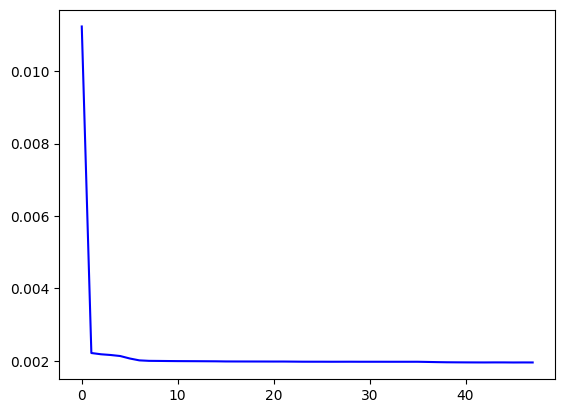

In [29]:
plt.plot(train_loss, label='train loss', color='blue', linestyle='-')
#保存模型
torch.save(model.state_dict(), 'CNN3D_state_dict.pth')

5


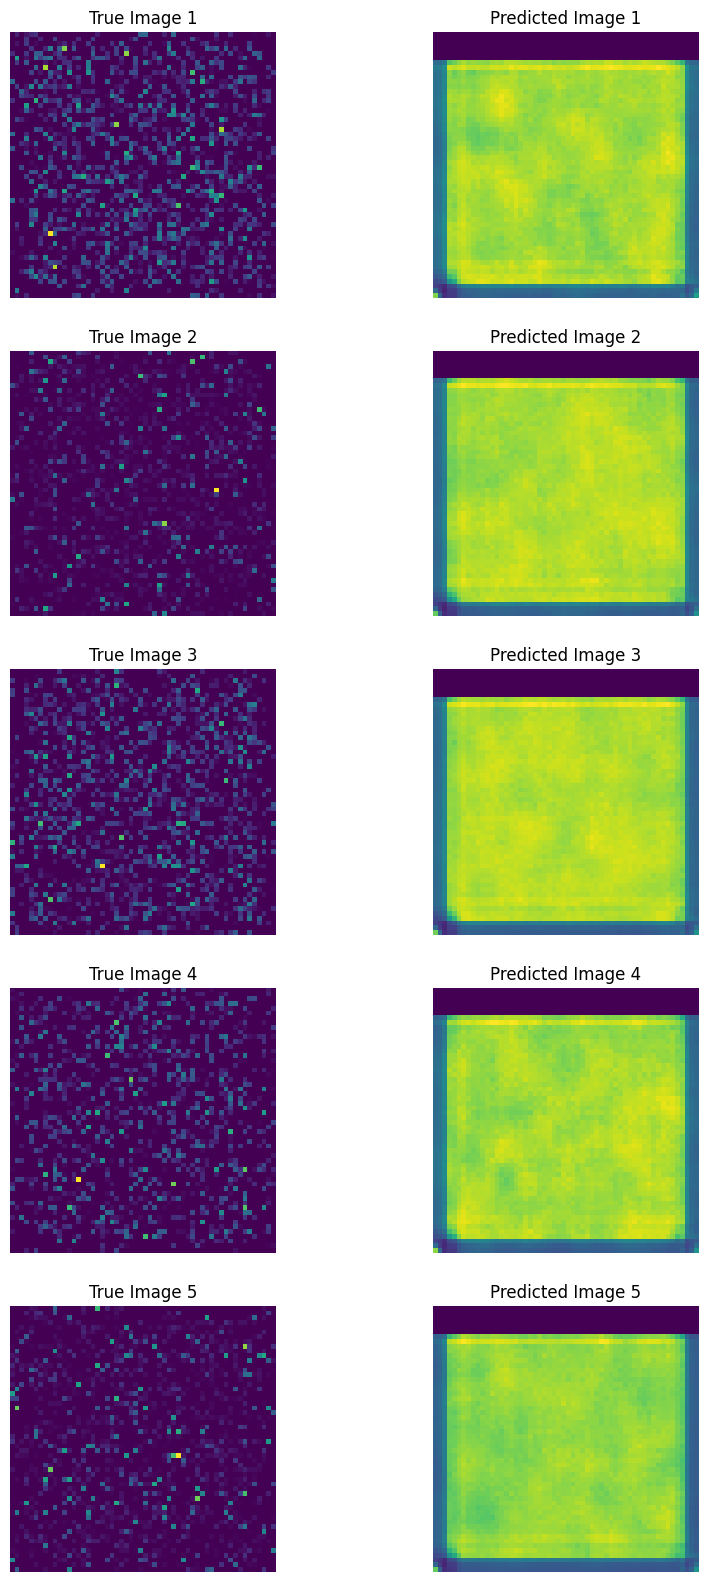

In [30]:
#在测试集/验证集/训练集上预测并画图
num_cases_to_plot=5
test_samples=list(test_loader)[:num_cases_to_plot]
model.eval()
predicted_images=[]
true_images=[]
print(len(test_samples))

with torch.no_grad():
    for X_test, Y_test in test_samples:
        # outputs=model(X_test.to(device),edge_index.to(device))
        outputs=model(X_test.to(device))
        predicted_images.append(outputs.cpu().detach().numpy())
        true_images.append(Y_test.cpu().detach().numpy())
predicted_images = np.concatenate(predicted_images, axis=0)
true_images = np.concatenate(true_images, axis=0)

IMAGE_NAME = 'Gauss_S1.00_NL0.30_B0.50'
error_list = []
pre_list = np.empty([])
true_list = np.empty([])
# Plotting the results
fig, axes = plt.subplots(num_cases_to_plot, 2, figsize=(10, 4 * num_cases_to_plot))
for i in range(num_cases_to_plot):
    # 假设只有单一通道要显示，可以通过 denormalized_predicted_images 和 denormalized_true_images 访问真实与预测结果
    #以下记得修改
    pred_img = predicted_images[i].reshape(HEIGHT, WIDTH) # 假设输出是单通道形式
    true_img = true_images[i, 0].reshape(HEIGHT, WIDTH) # 假设通道在第一维度
    # 绘制真实图像
    axes[i, 0].imshow(true_img) # 使用灰度图显示
    axes[i, 0].set_title(f'True Image {i+1}')
    axes[i, 0].axis('off')

    # 绘制预测图像
    axes[i, 1].imshow(pred_img) # 使用灰度图显示
    axes[i, 1].set_title(f'Predicted Image {i+1}')
    axes[i, 1].axis('off')
    error_list.append(pred_img-true_img)
    pre_list = np.append(pre_list,pred_img)
    true_list = np.append(true_list,true_img)
plt.show()

In [31]:
#计算测试集上的损失以及误差
errors = np.array([])
Y_test_1 = np.array([])
model.eval()
with torch.no_grad():
    test_loss=0
    for X_test, Y_test in test_loader:
        outputs=model(X_test.to(device))
        test_loss+=criterion(outputs, Y_test.to(device)).item()
        errors = np.append(errors,outputs.cpu().detach().numpy().reshape(-1)-Y_test.cpu().detach().numpy().reshape(-1))
        Y_test_1 = np.append(Y_test_1,Y_test.cpu().detach().numpy().reshape(-1))
    test_loss/=len(test_loader)
print(f'test loss: {test_loss}')
print(len(errors))

test loss: 0.0020045720040798186
3136000


In [32]:
#定义画图类
class Plotter:
    def __init__(self):
        pass
    def plot_histogram(self, data_list, num_bins=10, color='blue', title='Histogram',xlabel='Values',ylabel='Frequency',net = 'None',
                    text = 'None',need_log_scale=False,range=[-1,-1],image_info = 'None',data_points='0',alpha = 1,label = 'None'):
        # 计算范围
        data_min, data_max = np.min(data_list), np.max(data_list)
        if range == [-1,-1]:
            data_range = (data_min, data_max)
        else :
            data_range = range
        hist, bin_edges=np.histogram(data_list,bins=num_bins,range=data_range)
        max_bin_index = np.argmax(hist)
        max_bin_range = (bin_edges[max_bin_index], bin_edges[max_bin_index + 1])
        max_bin_freq = hist[max_bin_index] # 该 bin 的频率
        print(f"频率最高的 bin 的范围是: {max_bin_range}，频率为: {max_bin_freq}")
        plt.hist(data_list,bins=num_bins,range=data_range,histtype='stepfilled',align='mid',
                orientation='vertical',color=color, alpha = alpha, label = label)
        if need_log_scale:
            plt.yscale('log')
        plt.title(title,fontsize=13)
        plt.xlabel(xlabel,fontsize=12)
        plt.tick_params(labelsize=12)
        plt.ylabel(ylabel,fontsize=12)
        plt.legend()

频率最高的 bin 的范围是: (0.012799999999999978, 0.013600000000000001)，频率为: 11451


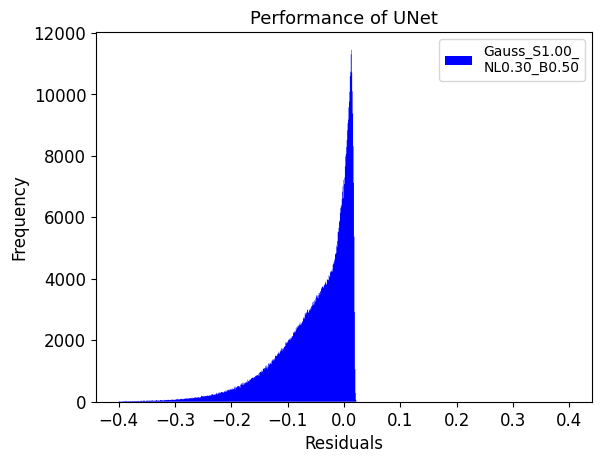

In [33]:
#绘制误差直方图
plotter3 = Plotter()
IMAGE_NAME = 'CNN3D'
errors_1 = [error for error,Y in zip(errors,Y_test_1) if Y !=0]
plotter3.plot_histogram(errors_1, num_bins=1000, color='blue',range = [-0.4,0.4],title='Performance of UNet',
                        xlabel='Residuals', ylabel='Frequency',net = 'UNet',
				        label = 'Gauss_S1.00_\nNL0.30_B0.50',image_info=IMAGE_NAME,data_points=str(len(errors)))

In [34]:
#计算误差的标准差
print(f'The std of the errors is {np.std(errors)}')

The std of the errors is 0.04472992320618551


errors_1 contains 813854 elements.


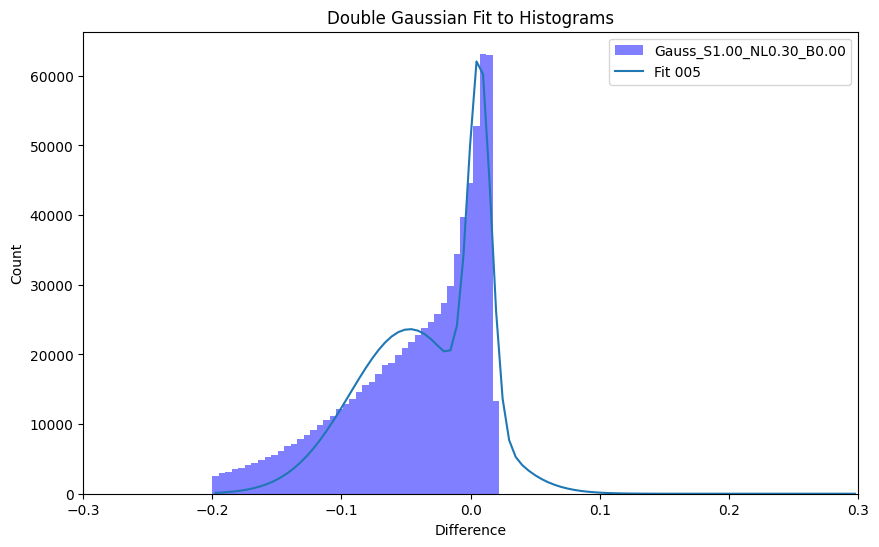

In [36]:
#为直方图拟合双高斯函数并画图
def double_gaussian(x, mu1, sigma1, amplitude1, mu2, sigma2, amplitude2):
    gauss1 = amplitude1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2))
    gauss2 = amplitude2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2))
    return gauss1 + gauss2

# Check if errors_1 is defined and contains data
if 'errors_1' in globals() and len(errors_1) > 0:
    print(f"errors_1 contains {len(errors_1)} elements.")
else:
    print("errors_1 is not defined or is empty.")

# Calculate the histogram data
bins = np.linspace(-0.2, 0.3, 100)
hist_005, bin_edges_005 = np.histogram(errors_1, bins=bins, density=False)
bin_centers_005 = (bin_edges_005[:-1] + bin_edges_005[1:]) / 2

# Convert histogram counts to density
bin_width = bin_edges_005[1] - bin_edges_005[0]
hist_density_005 = hist_005 / (len(errors_1) * bin_width)

# Fit the double Gaussian function to the histogram data
popt_005, _ = curve_fit(double_gaussian, bin_centers_005, hist_density_005, p0=[0, 0.01, 1, 0, 0.01, 1])

# Plot the histograms and the fitted double Gaussian functions
plt.figure(figsize=(10, 6))
plt.hist(errors_1, bins=bins, alpha=0.5, label='Gauss_S1.00_NL0.30_B0.00', density=False, range=[-0.3, 0.3], color='blue')
plt.plot(bin_centers_005, double_gaussian(bin_centers_005, *popt_005) * len(errors_1) * bin_width, label='Fit 005')
plt.xlim(-0.3, 0.3)
plt.xlabel('Difference')
plt.ylabel('Count')
plt.legend()
plt.title('Double Gaussian Fit to Histograms')
plt.show()
#保存误差列表为txt文件
np.savetxt('errors_CNN3D_nojet.txt', errors_1)

In [39]:
#导入jet数据集并预处理，加载数据迭代器
dataset1 = myDataSet(img_dir='/kaggle/input/Gauss_S1.00_NL0.30_B0.50_jet', group_size=1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
transform=transforms.Compose([
    transforms.ToTensor(),
    # 数据预处理后期添加
])
# 归一化处理，把所有像素值归一化到0-1
X=dataset1.X #(10000,4,56,56)
Y=dataset1.Y #(10000,1,56,56)

NameError: name 'myDataSet' is not defined

In [ ]:
torch.save(X, '/kaggle/working/X_withjet_dataset_general.pt')
torch.save(Y, '/kaggle/working/Y_withjet_dataset_general.pt')

In [ ]:
X = torch.load('/kaggle/working/X_withjet_datast_general.pt')
Y = torch.load('/kaggle/working/Y_withjet_dataset_general.pt')

In [ ]:
min_max_X_values = [] # 保存每个通道的 (min, max) 值
min_max_Y_values=[]
# 对X要分通道进行归一化
for i in range(4):
    x=X[:,i,:,:]
    x_max=x.max()
    x_min=x.min()
    min_max_X_values.append((x_min, x_max)) # 保存 min 和 max 值
    x_new=(x-x_min)/(x_max-x_min)
    X[:,i,:,:]=x_new
y_min=Y.min()
y_max=Y.max()
min_max_Y_values.append((y_min,y_max))
y_new=(Y-y_min)/(y_max-y_min)
Y=y_new
from dataset_2 import dataset_2 #找回被释放的内存
dataset1=dataset_2(X,Y)
#分割数据集
TEST_NUM=1000
BATCH_SIZE=200
print(TEST_NUM)
test_loader_jet = DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#从数据集中选择五组数据预测并画图
num_cases_to_plot = 5
test_samples_jet=list(test_loader_jet)[:num_cases_to_plot]
model.eval()
predicted_images=[]
true_images=[]
print(len(test_samples_jet))

with torch.no_grad():
    for X_test, Y_test in test_samples_jet:
        outputs=model(X_test.to(device))
        predicted_images.append(outputs.cpu().detach().numpy())
        true_images.append(Y_test.cpu().detach().numpy())
predicted_images = np.concatenate(predicted_images, axis=0)
true_images = np.concatenate(true_images, axis=0)

IMAGE_NAME = 'Gauss_S1.00_NL0.30_B0.50'
error_list = []
pre_list = np.empty([])
true_list = np.empty([])
# Plotting the results
fig, axes = plt.subplots(num_cases_to_plot, 2, figsize=(10, 4 * num_cases_to_plot))
# predicted_images = test_dataset
for i in range(num_cases_to_plot):
    # 假设只有单一通道要显示，可以通过 denormalized_predicted_images 和 denormalized_true_images 访问真实与预测结果
    pred_img = predicted_images[i, 0].reshape(HEIGHT, WIDTH) # 假设输出是单通道形式
    true_img = true_images[i, 0].reshape(HEIGHT, WIDTH) # 假设通道在第一维度
    # 绘制真实图像
    axes[i, 0].imshow(true_img) # 使用灰度图显示
    axes[i, 0].set_title(f'CNN True Image {i+1}')
    axes[i, 0].axis('off')

    # 绘制预测图像
    axes[i, 1].imshow(pred_img) # 使用灰度图显示
    axes[i, 1].set_title(f'CNN Predicted Image {i+1}')
    axes[i, 1].axis('off')
    error_list.append(pred_img-true_img)
    pre_list = np.append(pre_list,pred_img)
    true_list = np.append(true_list,true_img)
plt.tight_layout()
plt.show()

In [ ]:
import math
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
cnt=0
nums = []
# 创建一个初始长度为10且所有元素为0的一维数组
# torch.set_printoptions(threshold=np.inf)
# np.set_printoptions(threshold=np.inf)
# sys.stdout=open('UTran.txt','w')
n = 0
save_dir = "D:\LECINSUMMER\\final_version\\predictimg\\"
model.eval()
with torch.no_grad():
    for X_test, Y_test in test_loader_jet:
        outputs=model(X_test.to(device))
        for img in outputs:
                img = img.cpu().detach().view(56,56).numpy()*(Y_max - Y_min) + Y_min
                fname = "UTran predict" + str(n) + ".tiff"
                save_path = save_dir + fname
                n+=1
                io.imsave(save_path, img)
                print(f'{n+1} picture Done')

In [ ]:
''''''''''
第一个函数的目的是找到数组中最大的三个数及其位置
循环中，我们遍历每一张图片，寻找其中最大的三个数，并通过加权平均计算其位置，并预测jet所在位置的半径。
然后我们认为truth图像中计算得出的jet位置及其半径为正确位置及半径，并以该圆心和半径为基准画圆，计算truth和pre图像在圆内点的误差
同时，我们保留了truth图像中预测的点和半径的位置信息
'''''''''
import math
length = 1010
cnt=0
# 创建一个初始长度为10且所有元素为0的一维数组
numvalue = np.zeros(5)
numpos =np.zeros(5)
import heapq
#计算jet数据集的误差标准差
def top_three_largest_with_position(nums):
    # 使用nlargest获取前三大的数及其位置
    # nlargest返回的是一个元组列表，每个元组包含一个数和一个位置索引
    result = heapq.nlargest(3, enumerate(nums), key=lambda x: x[1])

    # 获取前三大的数和他们原来的位置
    largest_number_1, largest_index_1 = result[0]
    largest_number_2, largest_index_2 = result[1]
    largest_number_3, largest_index_3 = result[2]

    # 分别使用四个变量存储前三大的数和他们原来的位置
    first_largest_number = largest_number_1
    first_largest_index = largest_index_1
    second_largest_number = largest_number_2
    second_largest_index = largest_index_2
    third_largest_number = largest_number_3
    third_largest_index = largest_index_3

    return first_largest_number, first_largest_index, second_largest_number, second_largest_index, third_largest_number, third_largest_index

nums =np.zeros(56*56)
#result = top_three_largest_with_position(nums)
errors_jet = np.array([])
Y_test_1 = np.array([])
position_ture = np.array([])
pre=np.zeros(56*56)
tru=np.zeros(56*56)
model.eval()
with torch.no_grad():
    for X_test, Y_test in test_loader_jet:
        outputs=model(X_test.to(device))
        for output, truth in zip(outputs,Y_test):#output和turth都是56*56的tensor
            channels,height, width=output.shape
            for h in range(height):
                for w in range(width):
                    value =truth[0, h, w]
                    pre[h*WIDTH+w]=value
            numpos[1],numvalue[1] , numpos[2], numvalue[2], numpos[3], numvalue[3],= top_three_largest_with_position(pre)      
            numsum = numvalue[1] + numvalue[2] + numvalue[3]
            px=(numpos[1]*numvalue[1]/56+numpos[2]*numvalue[2]/56+numpos[3]*numvalue[3]/56)/numsum
            py=((numpos[1]%56)*numvalue[1]+(numpos[2]%56)*numvalue[2]+(numpos[3]%56)*numvalue[3])/numsum
            pr=0
            for i in range(3):
                pr=pr+math.sqrt((int(numpos[i+1]/56)-px)*(int(numpos[i+1]/56)-px)+((numpos[i+1]%56)-py)*((numpos[i+1]%56)-py))*numvalue[i+1]
            pr=pr/numsum
            print(f"cnt:  {cnt}   px: {px}  py: {py}   pr:{pr}")
            position_ture = np.append(position_ture,[px,py,pr])
            sum_tru=0
            sum_pre=0
            for h in range(height):
                for w in range(width):
                    value =truth[0, h, w]
                    if (h-px)*(h-px)+(w-py)*(w-py)<=pr*pr:
                        sum_tru+=value
            for h in range(height):
                for w in range(width):
                    value =output[0, h, w]
                    if (h-px)*(h-px)+(w-py)*(w-py)<=pr*pr:
                        sum_pre+=value
            print(f"sum_tru:  {sum_tru/3}  sum_pre: {sum_pre/3}")     
            errors_jet = np.append(errors_jet,(sum_pre/3-sum_tru/3).cpu().detach().numpy())
print(len(errors_jet))       
position_ture = position_ture.reshape(-1,3)
print(len(position_ture))

In [ ]:
'''''''''
计算并保留pre图像中预测的位置及半径。
'''
import math
length = 1010
cnt=0
# 创建一个初始长度为10且所有元素为0的一维数组
numvalue = np.zeros(5)
numpos =np.zeros(5)
import heapq
#计算jet数据集的误差标准差
def top_three_largest_with_position(nums):
    # 使用nlargest获取前三大的数及其位置
    # nlargest返回的是一个元组列表，每个元组包含一个数和一个位置索引
    result = heapq.nlargest(3, enumerate(nums), key=lambda x: x[1])

    # 获取前三大的数和他们原来的位置
    largest_number_1, largest_index_1 = result[0]
    largest_number_2, largest_index_2 = result[1]
    largest_number_3, largest_index_3 = result[2]

    # 分别使用四个变量存储前三大的数和他们原来的位置
    first_largest_number = largest_number_1
    first_largest_index = largest_index_1
    second_largest_number = largest_number_2
    second_largest_index = largest_index_2
    third_largest_number = largest_number_3
    third_largest_index = largest_index_3

    return first_largest_number, first_largest_index, second_largest_number, second_largest_index, third_largest_number, third_largest_index

nums =np.zeros(56*56)
errors = np.array([])
Y_test_1 = np.array([])
position_pre = np.array([])
pre=np.zeros(56*56)
tru=np.zeros(56*56)
model.eval()
with torch.no_grad():
    for X_test, Y_test in test_loader_jet:
        outputs=model(X_test.to(device))
        for output, truth in zip(outputs,Y_test):#output和turth都是56*56的tensor
            channels,height, width=output.shape
            for h in range(height):
                for w in range(width):
                    value =truth[0, h, w]
                    tru[h*WIDTH+w]=value
            numpos[1],numvalue[1] , numpos[2], numvalue[2], numpos[3], numvalue[3],= top_three_largest_with_position(tru)    
            numsum = numvalue[1] + numvalue[2] + numvalue[3]
            px=(numpos[1]*numvalue[1]/56+numpos[2]*numvalue[2]/56+numpos[3]*numvalue[3]/56)/numsum
            py=((numpos[1]%56)*numvalue[1]+(numpos[2]%56)*numvalue[2]+(numpos[3]%56)*numvalue[3])/numsum
            pr=0    
            for i in range(3):
                pr=pr+math.sqrt((int(numpos[i+1]/56)-px)*(int(numpos[i+1]/56)-px)+((numpos[i+1]%56)-py)*((numpos[i+1]%56)-py))*numvalue[i+1]
            pr=pr/numsum
            print(f"truth:   cnt:  {cnt}   px: {px}  py: {py}   pr:{pr}")
            sum_tru=0
            sum_pre=0
            for h in range(height):
                for w in range(width):
                    value =truth[0, h, w]
                    if (h-px)*(h-px)+(w-py)*(w-py)<=pr*pr:
                        sum_tru+=value
            for h in range(height):
                for w in range(width):
                    value =output[0, h, w]
                    if (h-px)*(h-px)+(w-py)*(w-py)<=pr*pr:
                        sum_pre+=value
            print(f"sum_tru:  {sum_tru}  sum_pre: {sum_pre}")    
            
            for h in range(height):
                for w in range(width):
                    value =output[0, h, w]
                    pre[h*WIDTH+w]=value
            numpos[1],numvalue[1] , numpos[2], numvalue[2], numpos[3], numvalue[3],= top_three_largest_with_position(pre)    
            numsum = numvalue[1] + numvalue[2] + numvalue[3]
            px=(numpos[1]*numvalue[1]/56+numpos[2]*numvalue[2]/56+numpos[3]*numvalue[3]/56)/numsum
            py=((numpos[1]%56)*numvalue[1]+(numpos[2]%56)*numvalue[2]+(numpos[3]%56)*numvalue[3])/numsum
            pr=0    
            for i in range(3):
                pr=pr+math.sqrt((int(numpos[i+1]/56)-px)*(int(numpos[i+1]/56)-px)+((numpos[i+1]%56)-py)*((numpos[i+1]%56)-py))*numvalue[i+1]
            pr=pr/numsum
            print(f"predicted:   cnt:  {cnt}   px: {px}  py: {py}   pr:{pr}")
            position_pre = np.append(position_pre,[px,py,pr])
            sum_tru=0
            sum_pre=0
            for h in range(height):
                for w in range(width):
                    value =truth[0, h, w]
                    if (h-px)*(h-px)+(w-py)*(w-py)<=pr*pr:
                        sum_tru+=value
            for h in range(height):
                for w in range(width):
                    value =output[0, h, w]
                    if (h-px)*(h-px)+(w-py)*(w-py)<=pr*pr:
                        sum_pre+=value
            print(f"sum_tru:  {sum_tru}  sum_pre: {sum_pre}")    
position_pre = position_pre.reshape(-1,3)
print(len(position_pre))

In [ ]:
#计算测试集上的损失以及误差
errors = np.array([])
Y_test_1 = np.array([])
model.eval()
with torch.no_grad():
    test_loss=0
    for X_test, Y_test in test_loader:
        outputs=model(X_test.to(device))
        test_loss+=criterion(outputs, Y_test.to(device)).item()
        errors = np.append(errors,outputs.cpu().detach().numpy().reshape(-1)-Y_test.cpu().detach().numpy().reshape(-1))
        Y_test_1 = np.append(Y_test_1,Y_test.cpu().detach().numpy().reshape(-1))
    test_loss/=len(test_loader)
print(f'test loss: {test_loss}')
print(len(errors))

In [ ]:
''''''''''
保存图像
'''
np.savetxt('jetposition_pred_UNet.txt', position_pre)
np.savetxt('jetposition_true_UNet.txt', position_ture)

In [ ]:
#绘制误差直方图
plotter3 = Plotter()
errors_1 = [error for error,Y in zip(errors,Y_test_1) if Y !=0]
plotter3.plot_histogram(errors_1, num_bins=1000, color='blue',range = [-0.4,0.4],title='Performance of UNet',
                        xlabel='Residuals', ylabel='Frequency',net = 'UNet',
			            label = 'Gauss_S1.00_\nNL0.30_B0.50',image_info=IMAGE_NAME,data_points=str(len(errors)))

In [ ]:
#为直方图拟合双高斯函数并画图
# Define the sum of two Gaussian functions
def double_gaussian(x, mu1, sigma1, amplitude1, mu2, sigma2, amplitude2):
    gauss1 = amplitude1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2))
    gauss2 = amplitude2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2))
    return gauss1 + gauss2

# Check if errors_1 is defined and contains data
if 'errors_1' in globals() and len(errors_1) > 0:
    print(f"errors_1 contains {len(errors_1)} elements.")
else:
    print("errors_1 is not defined or is empty.")

# Calculate the histogram data
bins = np.linspace(-0.2, 0.3, 100)
hist_005, bin_edges_005 = np.histogram(errors_1, bins=bins, density=False)
bin_centers_005 = (bin_edges_005[:-1] + bin_edges_005[1:]) / 2

# Convert histogram counts to density
bin_width = bin_edges_005[1] - bin_edges_005[0]
hist_density_005 = hist_005 / (len(errors_1) * bin_width)

# Fit the double Gaussian function to the histogram data
popt_005, _ = curve_fit(double_gaussian, bin_centers_005, hist_density_005, p0=[0, 0.01, 1, 0, 0.01, 1])

# Plot the histograms and the fitted double Gaussian functions
plt.figure(figsize=(10, 6))
plt.hist(errors_1, bins=bins, alpha=0.5, label='Gauss_S1.00_NL0.30_B0.00', density=False, range=[-0.3, 0.3], color='blue')
plt.plot(bin_centers_005, double_gaussian(bin_centers_005, *popt_005) * len(errors_1) * bin_width, label='Fit 005')
plt.xlim(-0.3, 0.3)
plt.xlabel('Difference')
plt.ylabel('Count')
plt.legend()
plt.title('Double Gaussian Fit to Histograms')
plt.show()

In [ ]:
#保存误差列表为txt文件
np.savetxt('errors_CNN3D_jet.txt', errors_1)